# Theano, Lasagne
и с чем их едят

Ещё не установили их - пока __```pip install theano```__ или __```conda install Theano```__, а после - установите

# разминка
* напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
* массив чисел от 0 до N - numpy.arange(N)

In [13]:
import numpy as np
def sum_squares(N):
    return (np.arange(N)**2).sum

In [14]:
%%time
sum_squares(10**8)

CPU times: user 996 ms, sys: 1.07 s, total: 2.06 s
Wall time: 2.08 s


<function sum>

# theano teaser

Как сделать то же самое

In [8]:
import theano
import theano.tensor as T

In [19]:
#будущий параметр функции
N = T.scalar("a dimension",dtype='int32')

#рецепт получения суммы квадратов
result = T.arange(N)
result **= 2
result = result.sum()

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs = [N],outputs=result)

In [24]:
from theano.printing import debugprint

debugprint(result)

Sum{acc_dtype=int64} [id A] ''   
 |Elemwise{pow,no_inplace} [id B] ''   
   |ARange{dtype='int64'} [id C] ''   
   | |TensorConstant{0} [id D]
   | |a dimension [id E]
   | |TensorConstant{1} [id F]
   |DimShuffle{x} [id G] ''   
     |TensorConstant{2} [id H]


In [20]:
%%time
sum_function(10**8)

CPU times: user 984 ms, sys: 440 ms, total: 1.42 s
Wall time: 1.44 s


array(662921401752298880)

# Как оно работает?
__Если вы читаете это в аудитории - скорее всего прямо сейчас преподы объясняют то же самое__
* Нужно написать "рецепт" получения выходов по входам
* То же самое на заумном: нужно описать символический граф вычислений


* 2 вида зверей - "входы" и "преобразования"
* Оба могут быть числами, массивами, матрицами, тензорами и т.п.


* Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.
 * N - вход в примере выше


* Преобразования - рецепты вычисления чего-то на основе входов и констант
 * (T.arange(N)^2).sum() - 3 последовательных преобразования N
 * Работают почти 1 в 1 как векторные операции в numpy
 * почти всё, что есть в numpy есть в theano tensor и называется так же
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * и так далее...
   * Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла
 
 
Ничего не понятно? Сейчас исправим.

In [25]:
#входы
example_input_integer = T.scalar("вход - одно число(пример)",dtype='float32')

example_input_tensor = T.tensor4("вход - четырёхмерный тензор(пример)")
#не бойся, тензор нам не пригодится



input_vector = T.vector("вход - вектор целых чисел", dtype='int32')


In [26]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector


In [8]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [31]:
#теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector("german", dtype='float32')
my_vector2 = T.vector("we", dtype='float32')

In [32]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector*my_vector2 / (T.sin(my_vector)+1)

In [33]:
print my_transformation
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


In [34]:
debugprint(my_transformation)

Elemwise{true_div,no_inplace} [id A] ''   
 |Elemwise{mul,no_inplace} [id B] ''   
 | |german [id C]
 | |we [id D]
 |Elemwise{add,no_inplace} [id E] ''   
   |Elemwise{sin,no_inplace} [id F] ''   
   | |german [id C]
   |DimShuffle{x} [id G] ''   
     |TensorConstant{1} [id H]


# Компиляция
* До этого момента, мы использовали "символические" переменные
 * писали рецепт вычислений, но ничего не вычисляли
* чтобы рецепт можно было использовать, его нужно скомпилировать

In [39]:
inputs = [my_vector,my_vector2]
outputs = my_transformation

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [40]:
#можно вызвать вот-так:
print "using python lists:"
print my_function([1,2,3],[4,5,6])
print

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print "using numpy arrays:"
print my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float'))


using python lists:
[  2.1721766    5.23752832  15.77397728]

using numpy arrays:
[   0.            2.77555895    5.47030783   14.02131271   89.5477066
  676.25805664   47.183918     24.4084301    23.68156242   38.24041748]


# хинт для отладки
* Если ваша функция большая, компиляция может отнять какое-то время.
* Чтобы не ждать, можно посчитать выражение без компиляции
* Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее


In [ ]:
#словарик значений для входов
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print my_transformation.eval(my_function_inputs)


#можно вычислять преобразования на ходу
print "сумма 2 векторов", (my_vector + my_vector2).eval(my_function_inputs)

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print "форма первого вектора", my_vector.shape.eval({
        my_vector:[1,2,3]
    })


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
* Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам
__[2 балла]__

In [ ]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно

<твой код - входы и преобразования>

compute_mse =<твой код - компиляция функции>

In [ ]:
#тесты
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print 'Wrong result:'
                print 'mse(%s,%s)'%(el,el_2)
                print "should be: %f, but your function returned %f"%(true_mse,my_mse)
                raise ValueError,"Что-то не так"

print "All tests passed"
            
    

# Shared variables

* Входы и преобразования - части рецепта. 
 * Они существуют только во время вызова функции.


* Shared переменные - всегда остаются в памяти
 * им можно поменять значение 
   * (но не внутри символического графа. Об этом позже)
 * их можно включить в граф вычислений
 
 
* хинт - в таких переменных удобно хранить параметры и гиперпараметры
 * например, веса нейронки или learning rate, если вы его меняете

In [41]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10,dtype='float64'))

In [43]:
#получить (численное) значение переменной
print "initial value",shared_vector_1.get_value()

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [44]:
#задать новое значение
shared_vector_1.set_value( np.arange(5) )

#проверим значение
print "new value", shared_vector_1.get_value()

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

new value [ 0.  1.  2.  3.  4.]


# Теперь сам

In [47]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = shared_vector_1*input_scalar

inputs = [input_scalar]
outputs = scalar_times_shared

shared_times_n = theano.function(
    inputs,outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [48]:
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)


shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [  0.   5.  10.  15.  20.]
shared_times_n(-0.5) [-0.  -0.5 -1.  -1.5 -2. ]


In [49]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1,0,1])
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)


shared: [-1.  0.  1.]
shared_times_n(5) [-5.  0.  5.]
shared_times_n(-0.5) [ 0.5 -0.  -0.5]


# T.grad, самое вкусное
* theano умеет само считать производные. Все, которые существуют.
* Производные считаются в символическом, а не численном виде

Ограничения
* За раз можно считать производную __скалярной__ функции по одной или нескольким скалярным или векторным аргументам
* Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [51]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

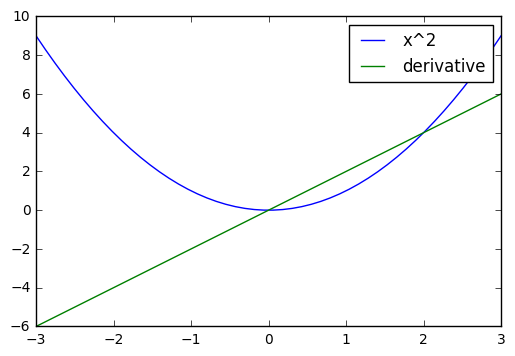

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3,3)
x_squared = map(fun,x)
x_squared_der = map(grad,x)

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# теперь сам

In [53]:
my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar,der_by_vector = T.grad(weird_psychotic_function,[my_scalar,my_vector])


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)

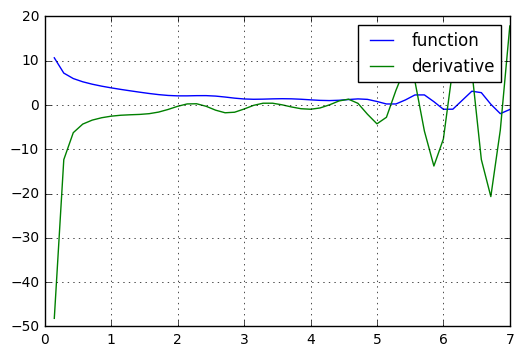

In [54]:
#график функции и твоей производной
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


# Последний штрих - Updates

* updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции

* фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции

Например,

In [55]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1:scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [84]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print "initial shared value:" ,shared_vector_1.get_value()

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print "compute_and_save(2) returns",compute_and_save(2)

#проверим, что в shared_vector_1
print "new shared value:" ,shared_vector_1.get_value()

initial shared value: [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 0.,  2.,  4.,  6.,  8.])]
new shared value: [ 0.  2.  4.  6.  8.]


# Логистическая регрессия
__[4 балла]__

Задача - собрать свою собственную логистическую регрессию с блэкджеком и кроссэнтропией.

Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [85]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target


print "y [форма - %s]:"%(str(y.shape)),y[:10]

print "X [форма - %s]:"%(str(X.shape))
print X[:3]

y [форма - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [форма - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [ ]:
# переменные и входы
shared_weights = theano.shared(np.zeros(64),dtype='float64')
input_X = T.matrix()
input_y = T.ivector()

In [ ]:
predicted_y = 1./(1+2.71**(-input_X.dot(shared_weights)))
loss = <логистическая ошибка (число - среднее по выборке)>

grad = <градиент loss по весам модели>



updates = {
    shared_weights: <новое значение весов после шага градиентного спуска>
}

In [ ]:
train_function = <функция, которая по X и Y возвращает ошибку и обновляет веса>
predict_function = <функция, которая по X считает предсказание для y>

In [ ]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [ ]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train,y_train)
    print "loss at iter %i:%.4f"%(i,loss_i)
    print "train auc:",roc_auc_score(y_train,predict_function(X_train))
    print "test auc:",roc_auc_score(y_test,predict_function(X_test))

    
print "resulting weights:"
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

# Нейроночка
__[базовая часть - 4 балла]__

Ваше финальное задание - сделать свою первую нейронку [почти] из спичек и желудей (theano).

В этот раз распознавание цифр зашло чуть дальше:
* картинки 28x28
* 10 классов
* 50k+ картинок только в обучающей выборке

Вам не нужно (но можно) создавать монстров на 152 слоя, не нужно ничего сворачивать - достаточно сделать простую нейросеть с 1 скрытым и 1 выходным слоем, которая будет работать лучше логистической регрессии.

В конце есть шаблон отчёта - его желательно вести по ходу работ (ну или хотя бы не забыть).

__[bonus score]__
Далее, если ваша сетка уже __побила результаты линейной модели__, а запал остался - можно попробовать улучшить результат ещё дальше. 
Челлендж - превзойти рубежи 95%/97.5%/98.5% точности на тесте __без использования свёрток__.

__СПОЙЛЕР!__ В конце тетрадки есть несколько советов по реализации. Если вы чувствуете в себе силы выстрелить в ногу самостоятельно - ваша воля, но наткнувшись на неразрешимые проблемы будьте добры прочитать "хвост" тетрадки, прежде, чем писать на почту.

In [17]:
from mnist import load_dataset

#качаем (по необходимости) и читаем данные.
#Важно, что для обучения можно использовать только train, 
#а val - для оценки прогресса, сравнения можелей и early stopping.
#Тест вообще лучше положить под камень до самого конца, но ктоЖ вас поймает.
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print X_train.shape,y_train.shape

(50000, 1, 28, 28) (50000,)


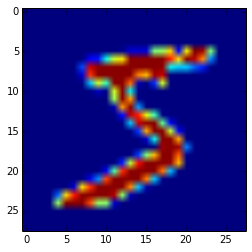

In [18]:
plt.imshow(X_train[0,0])

In [ ]:
<Тут, например, можно запилить граф вычислений>

In [ ]:
<а тут - посчитать функцию потерь и updates>

In [ ]:
<а тут - скомпилировать нужные функции>

In [ ]:
<а тут - запилить цикл обучения и нужные метрики>

In [ ]:
<и наконец тут - предсказание на тесте - только честно!>

# Отчёт

Я делал такое и такое. Потом попробовал вот-такое и алгоритм выдал вот-такое. А потом я его стукнул и он стал фиолетовый в крапинку. А ещё мне очень помогла вон-та статья и вот-этот сорт травы (if any).




```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Рекомендуемый порядок:

* Адаптировать логистическую регрессию на класиффикацию 1 цифры против всех (например, нулей против ненулей)
* Обобщить логистическую регрессию до многоклассовой.
  - для этого придётся вспомнить первую лекцию или загуглить.
  - вместо одного вектора весов у вас будет матрица (признак, класс)
  - softmax (экспонента на сумму экспонент) можно сделать самому, а можно - T.nnet.softmax (стабильная)
  - Лучше использовать стохастический градиентный спуск (минибатчевый)
   - в котором случае выборку желательно перемешать (ну или брать случайный набор примеров на каждой итерации обучения)
* Добавить скрытый слой. Теперь ваша логистическая регрессия опирается на нейроны, а не на входы. 
  - Принцип работы первого слоя - такой же, как у выходного, но вместо softmax у него другая нелинейность. 
  - нужно обучать оба слоя, а не только выходной :)
  - важно не инициализировать веса нулями из-за эффекта симметрии. Для начала - случайный нормальный шум с маленькой "сигмой".
  - Начать рекоммендую с 50 нейронов и сигмоиды, ибо так труднее прострелить себе ногу. 
  - В идеале у вас будет 2 .dot-а, 1 sigmoid и 1 softmax. 
  - __Убедитесь, что такая нейронка выучивается лучше, чем логистическая регрессия__
  
* Теперь время подумать над тем, как улучшить результат. Слои, нейроны, нелинейности, методы оптимизации, инициализация - всё, что хотите, разве что я бы попросил в качестве челленджа обойтись пока без свёрток.
  